# Method 6 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

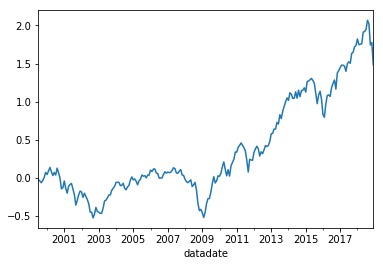

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.068094
2000-12-31   -0.188814
2001-12-31   -0.051157
2002-12-31   -0.325436
2003-12-31    0.595832
2004-12-31    0.139558
2005-12-31    0.023586
2006-12-31    0.025641
2007-12-31   -0.028298
2008-12-31   -0.433180
2009-12-31    0.754177
2010-12-31    0.306289
2011-12-31   -0.081820
2012-12-31    0.202920
2013-12-31    0.387116
2014-12-31    0.065013
2015-12-31   -0.068336
2016-12-31    0.184770
2017-12-31    0.137769
2018-12-31   -0.093052
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     673.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.45e-125
Time:                        15:00:01   Log-Likelihood:                 616.76
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     229   BIC:                            -1206.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.345      0.180      -0.001       0.004
mktrf          1.0919      0.033     33.396      0.000       1.027       1.156
me             0.2790      0.038      7.336      0.000       0.204       0.354
ia             0.2205      0.058      3.816      0.000       0.107       0.334
roe           -0.4604      0.049     -9.304      0.000      -0.558      -0.363
==============================================================================
Omnibus:                       33.393   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.050
Skew:                           0.395   Prob(JB):                     3.53e-34
Kurtosis:                       6.896   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     374.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.55e-99
Time:                        15:00:01   Log-Likelihood:                 616.76
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     229   BIC:                            -1206.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.247      0.212      -0.001       0.004
mktrf          1.0919      0.055     19.923      0.000       0.984       1.199
me             0.2790      0.127      2.194      0.028       0.030       0.528
ia             0.2205      0.118      1.865      0.062      -0.011       0.452
roe           -0.4604      0.099     -4.634      0.000      -0.655      -0.266
==============================================================================
Omnibus:                       33.393   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.050
Skew:                           0.395   Prob(JB):                     3.53e-34
Kurtosis:                       6.896   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     353.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-96
Time:                        15:00:01   Log-Likelihood:                 616.76
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     229   BIC:                            -1206.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.229      0.219      -0.001       0.004
mktrf          1.0919      0.056     19.595      0.000       0.983       1.201
me             0.2790      0.134      2.087      0.037       0.017       0.541
ia             0.2205      0.116      1.894      0.058      -0.008       0.449
roe           -0.4604      0.106     -4.336      0.000      -0.668      -0.252
==============================================================================
Omnibus:                       33.393   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.050
Skew:                           0.395   Prob(JB):                     3.53e-34
Kurtosis:                       6.896   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     474.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.45e-118
Time:                        15:00:01   Log-Likelihood:                 603.61
No. Observations:                 234   AIC:                            -1195.
Df Residuals:                     228   BIC:                            -1174.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.696      0.487      -0.002       0.003
mktrf          1.1383      0.035     32.778      0.000       1.070       1.207
smb            0.3564      0.046      7.779      0.000       0.266       0.447
hml            0.2833      0.054      5.243      0.000       0.177       0.390
rmw           -0.3225      0.061     -5.279      0.000      -0.443      -0.202
cma           -0.0896      0.078     -1.154      0.250      -0.243       0.063
==============================================================================
Omnibus:                       39.455   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.464
Skew:                           0.636   Prob(JB):                     1.41e-30
Kurtosis:                       6.533   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     262.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.08e-92
Time:                        15:00:01   Log-Likelihood:                 603.61
No. Observations:                 234   AIC:                            -1195.
Df Residuals:                     228   BIC:                            -1174.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.580      0.562      -0.002       0.004
mktrf          1.1383      0.048     23.874      0.000       1.045       1.232
smb            0.3564      0.113      3.154      0.002       0.135       0.578
hml            0.2833      0.103      2.752      0.006       0.082       0.485
rmw           -0.3225      0.120     -2.684      0.007      -0.558      -0.087
cma           -0.0896      0.167     -0.536      0.592      -0.417       0.238
==============================================================================
Omnibus:                       39.455   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.464
Skew:                           0.636   Prob(JB):                     1.41e-30
Kurtosis:                       6.533   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     280.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-95
Time:                        15:00:01   Log-Likelihood:                 603.61
No. Observations:                 234   AIC:                            -1195.
Df Residuals:                     228   BIC:                            -1174.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.531      0.595      -0.002       0.004
mktrf          1.1383      0.046     24.730      0.000       1.048       1.229
smb            0.3564      0.111      3.197      0.001       0.138       0.575
hml            0.2833      0.092      3.067      0.002       0.102       0.464
rmw           -0.3225      0.126     -2.562      0.010      -0.569      -0.076
cma           -0.0896      0.169     -0.529      0.596      -0.421       0.242
==============================================================================
Omnibus:                       39.455   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.464
Skew:                           0.636   Prob(JB):                     1.41e-30
Kurtosis:                       6.533   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     856.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.96e-136
Time:                        15:00:02   Log-Likelihood:                 642.89
No. Observations:                 234   AIC:                            -1276.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.649      0.517      -0.001       0.003
mktrf          1.1049      0.027     41.043      0.000       1.052       1.158
smb            0.5235      0.034     15.578      0.000       0.457       0.590
hml            0.1615      0.033      4.837      0.000       0.096       0.227
umd           -0.2611      0.022    -11.923      0.000      -0.304      -0.218
==============================================================================
Omnibus:                       16.620   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.932
Skew:                           0.357   Prob(JB):                     1.16e-07
Kurtosis:                       4.663   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     480.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.29e-110
Time:                        15:00:02   Log-Likelihood:                 642.89
No. Observations:                 234   AIC:                            -1276.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.631      0.528      -0.001       0.003
mktrf          1.1049      0.030     37.437      0.000       1.047       1.163
smb            0.5235      0.082      6.402      0.000       0.363       0.684
hml            0.1615      0.049      3.317      0.001       0.066       0.257
umd           -0.2611      0.040     -6.523      0.000      -0.340      -0.183
==============================================================================
Omnibus:                       16.620   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.932
Skew:                           0.357   Prob(JB):                     1.16e-07
Kurtosis:                       4.663   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     424.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-104
Time:                        15:00:02   Log-Likelihood:                 642.89
No. Observations:                 234   AIC:                            -1276.
Df Residuals:                     229   BIC:                            -1258.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.667      0.505      -0.001       0.003
mktrf          1.1049      0.032     34.320      0.000       1.042       1.168
smb            0.5235      0.088      5.952      0.000       0.351       0.696
hml            0.1615      0.046      3.524      0.000       0.072       0.251
umd           -0.2611      0.038     -6.904      0.000      -0.335      -0.187
==============================================================================
Omnibus:                       16.620   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.932
Skew:                           0.357   Prob(JB):                     1.16e-07
Kurtosis:                       4.663   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     332.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.38e-62
Time:                        15:00:02   Log-Likelihood:                 300.54
No. Observations:                 120   AIC:                            -591.1
Df Residuals:                     115   BIC:                            -577.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.188      0.237      -0.002       0.006
mktrf          1.1025      0.052     21.177      0.000       0.999       1.206
me             0.1676      0.051      3.260      0.001       0.066       0.270
ia             0.2415      0.081      2.999      0.003       0.082       0.401
roe           -0.4747      0.071     -6.660      0.000      -0.616      -0.333
==============================================================================
Omnibus:                        3.393   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.782
Skew:                          -0.033   Prob(JB):                        0.151
Kurtosis:                       3.867   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     228.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.18e-54
Time:                        15:00:02   Log-Likelihood:                 300.54
No. Observations:                 120   AIC:                            -591.1
Df Residuals:                     115   BIC:                            -577.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.136      0.256      -0.002       0.006
mktrf          1.1025      0.063     17.576      0.000       0.980       1.225
me             0.1676      0.122      1.377      0.169      -0.071       0.406
ia             0.2415      0.127      1.903      0.057      -0.007       0.490
roe           -0.4747      0.108     -4.392      0.000      -0.686      -0.263
==============================================================================
Omnibus:                        3.393   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.782
Skew:                          -0.033   Prob(JB):                        0.151
Kurtosis:                       3.867   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     196.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.23e-50
Time:                        15:00:02   Log-Likelihood:                 300.54
No. Observations:                 120   AIC:                            -591.1
Df Residuals:                     115   BIC:                            -577.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.188      0.235      -0.001       0.006
mktrf          1.1025      0.064     17.351      0.000       0.978       1.227
me             0.1676      0.127      1.320      0.187      -0.081       0.417
ia             0.2415      0.126      1.913      0.056      -0.006       0.489
roe           -0.4747      0.114     -4.167      0.000      -0.698      -0.251
==============================================================================
Omnibus:                        3.393   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.183   Jarque-Bera (JB):                3.782
Skew:                          -0.033   Prob(JB):                        0.151
Kurtosis:                       3.867   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     217.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-56
Time:                        15:00:02   Log-Likelihood:                 289.98
No. Observations:                 120   AIC:                            -568.0
Df Residuals:                     114   BIC:                            -551.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.998      0.321      -0.002       0.006
mktrf          1.2048      0.060     20.009      0.000       1.085       1.324
smb            0.2679      0.068      3.928      0.000       0.133       0.403
hml            0.2376      0.084      2.843      0.005       0.072       0.403
rmw           -0.2870      0.099     -2.913      0.004      -0.482      -0.092
cma           -0.0495      0.108     -0.458      0.648      -0.263       0.164
==============================================================================
Omnibus:                        9.932   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.251
Skew:                           0.411   Prob(JB):                     0.000804
Kurtosis:                       4.475   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     110.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.89e-42
Time:                        15:00:02   Log-Likelihood:                 289.98
No. Observations:                 120   AIC:                            -568.0
Df Residuals:                     114   BIC:                            -551.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.884      0.377      -0.003       0.007
mktrf          1.2048      0.067     18.015      0.000       1.074       1.336
smb            0.2679      0.137      1.950      0.051      -0.001       0.537
hml            0.2376      0.101      2.343      0.019       0.039       0.436
rmw           -0.2870      0.119     -2.409      0.016      -0.521      -0.053
cma           -0.0495      0.199     -0.248      0.804      -0.440       0.341
==============================================================================
Omnibus:                        9.932   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.251
Skew:                           0.411   Prob(JB):                     0.000804
Kurtosis:                       4.475   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.61e-41
Time:                        15:00:02   Log-Likelihood:                 289.98
No. Observations:                 120   AIC:                            -568.0
Df Residuals:                     114   BIC:                            -551.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.003      0.846      0.398      -0.003       0.007
mktrf          1.2048      0.062     19.413      0.000       1.083       1.326
smb            0.2679      0.130      2.064      0.039       0.014       0.522
hml            0.2376      0.098      2.430      0.015       0.046       0.429
rmw           -0.2870      0.122     -2.344      0.019      -0.527      -0.047
cma           -0.0495      0.201     -0.246      0.806      -0.443       0.344
==============================================================================
Omnibus:                        9.932   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.251
Skew:                           0.411   Prob(JB):                     0.000804
Kurtosis:                       4.475   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     446.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.87e-69
Time:                        15:00:02   Log-Likelihood:                 317.00
No. Observations:                 120   AIC:                            -624.0
Df Residuals:                     115   BIC:                            -610.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.834      0.406      -0.002       0.005
mktrf          1.1373      0.040     28.442      0.000       1.058       1.217
smb            0.4569      0.046     10.035      0.000       0.367       0.547
hml            0.1282      0.046      2.812      0.006       0.038       0.219
umd           -0.2599      0.028     -9.244      0.000      -0.316      -0.204
==============================================================================
Omnibus:                        1.335   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.877
Skew:                           0.049   Prob(JB):                        0.645
Kurtosis:                       3.407   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     328.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.05e-62
Time:                        15:00:02   Log-Likelihood:                 317.00
No. Observations:                 120   AIC:                            -624.0
Df Residuals:                     115   BIC:                            -610.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.798      0.425      -0.002       0.005
mktrf          1.1373      0.045     25.537      0.000       1.050       1.225
smb            0.4569      0.087      5.268      0.000       0.287       0.627
hml            0.1282      0.062      2.083      0.037       0.008       0.249
umd           -0.2599      0.044     -5.967      0.000      -0.345      -0.175
==============================================================================
Omnibus:                        1.335   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.877
Skew:                           0.049   Prob(JB):                        0.645
Kurtosis:                       3.407   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     494.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.87e-71
Time:                        15:00:02   Log-Likelihood:                 317.00
No. Observations:                 120   AIC:                            -624.0
Df Residuals:                     115   BIC:                            -610.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.900      0.368      -0.002       0.004
mktrf          1.1373      0.047     24.142      0.000       1.045       1.230
smb            0.4569      0.095      4.803      0.000       0.270       0.643
hml            0.1282      0.068      1.893      0.058      -0.005       0.261
umd           -0.2599      0.039     -6.580      0.000      -0.337      -0.182
==============================================================================
Omnibus:                        1.335   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.877
Skew:                           0.049   Prob(JB):                        0.645
Kurtosis:                       3.407   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     536.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-70
Time:                        15:00:02   Log-Likelihood:                 349.54
No. Observations:                 114   AIC:                            -689.1
Df Residuals:                     109   BIC:                            -675.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.186      0.031       0.000       0.005
mktrf          0.9945      0.034     29.334      0.000       0.927       1.062
me             0.6388      0.052     12.204      0.000       0.535       0.743
ia             0.1161      0.073      1.598      0.113      -0.028       0.260
roe           -0.4636      0.064     -7.266      0.000      -0.590      -0.337
==============================================================================
Omnibus:                      115.371   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2309.255
Skew:                           3.266   Prob(JB):                         0.00
Kurtosis:                      24.059   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     404.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.07e-64
Time:                        15:00:02   Log-Likelihood:                 349.54
No. Observations:                 114   AIC:                            -689.1
Df Residuals:                     109   BIC:                            -675.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.972      0.049    1.47e-05       0.005
mktrf          0.9945      0.031     32.109      0.000       0.934       1.055
me             0.6388      0.052     12.184      0.000       0.536       0.742
ia             0.1161      0.073      1.585      0.113      -0.027       0.260
roe           -0.4636      0.103     -4.520      0.000      -0.665      -0.263
==============================================================================
Omnibus:                      115.371   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2309.255
Skew:                           3.266   Prob(JB):                         0.00
Kurtosis:                      24.059   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     465.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-67
Time:                        15:00:02   Log-Likelihood:                 349.54
No. Observations:                 114   AIC:                            -689.1
Df Residuals:                     109   BIC:                            -675.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.019      0.043    7.39e-05       0.005
mktrf          0.9945      0.030     32.687      0.000       0.935       1.054
me             0.6388      0.062     10.237      0.000       0.517       0.761
ia             0.1161      0.071      1.630      0.103      -0.024       0.256
roe           -0.4636      0.102     -4.557      0.000      -0.663      -0.264
==============================================================================
Omnibus:                      115.371   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2309.255
Skew:                           3.266   Prob(JB):                         0.00
Kurtosis:                      24.059   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     371.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.71e-66
Time:                        15:00:02   Log-Likelihood:                 342.20
No. Observations:                 114   AIC:                            -672.4
Df Residuals:                     108   BIC:                            -656.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.998      0.320      -0.001       0.004
mktrf          1.0226      0.035     29.518      0.000       0.954       1.091
smb            0.6066      0.056     10.785      0.000       0.495       0.718
hml            0.2319      0.072      3.233      0.002       0.090       0.374
rmw           -0.3859      0.088     -4.394      0.000      -0.560      -0.212
cma           -0.0129      0.111     -0.115      0.908      -0.234       0.208
==============================================================================
Omnibus:                       75.465   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.552
Skew:                           2.142   Prob(JB):                    6.79e-113
Kurtosis:                      12.508   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     382.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.97e-67
Time:                        15:00:02   Log-Likelihood:                 342.20
No. Observations:                 114   AIC:                            -672.4
Df Residuals:                     108   BIC:                            -656.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.846      0.398      -0.002       0.004
mktrf          1.0226      0.027     38.525      0.000       0.971       1.075
smb            0.6066      0.056     10.835      0.000       0.497       0.716
hml            0.2319      0.124      1.865      0.062      -0.012       0.476
rmw           -0.3859      0.101     -3.819      0.000      -0.584      -0.188
cma           -0.0129      0.096     -0.134      0.894      -0.202       0.176
==============================================================================
Omnibus:                       75.465   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.552
Skew:                           2.142   Prob(JB):                    6.79e-113
Kurtosis:                      12.508   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     357.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-65
Time:                        15:00:02   Log-Likelihood:                 342.20
No. Observations:                 114   AIC:                            -672.4
Df Residuals:                     108   BIC:                            -656.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.783      0.434      -0.002       0.004
mktrf          1.0226      0.027     37.814      0.000       0.970       1.076
smb            0.6066      0.065      9.386      0.000       0.480       0.733
hml            0.2319      0.108      2.143      0.032       0.020       0.444
rmw           -0.3859      0.097     -3.996      0.000      -0.575      -0.197
cma           -0.0129      0.080     -0.160      0.873      -0.170       0.145
==============================================================================
Omnibus:                       75.465   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.552
Skew:                           2.142   Prob(JB):                    6.79e-113
Kurtosis:                      12.508   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     456.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.39e-67
Time:                        15:00:02   Log-Likelihood:                 340.82
No. Observations:                 114   AIC:                            -671.6
Df Residuals:                     109   BIC:                            -658.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.891      0.375      -0.001       0.004
mktrf          1.0295      0.035     29.682      0.000       0.961       1.098
smb            0.7052      0.054     13.039      0.000       0.598       0.812
hml            0.2426      0.056      4.356      0.000       0.132       0.353
umd           -0.1800      0.042     -4.285      0.000      -0.263      -0.097
==============================================================================
Omnibus:                       62.025   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.417
Skew:                           1.667   Prob(JB):                     6.81e-88
Kurtosis:                      11.567   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     454.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.18e-67
Time:                        15:00:02   Log-Likelihood:                 340.82
No. Observations:                 114   AIC:                            -671.6
Df Residuals:                     109   BIC:                            -658.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      0.766      0.444      -0.002       0.004
mktrf          1.0295      0.030     34.283      0.000       0.971       1.088
smb            0.7052      0.047     15.050      0.000       0.613       0.797
hml            0.2426      0.095      2.556      0.011       0.057       0.429
umd           -0.1800      0.062     -2.896      0.004      -0.302      -0.058
==============================================================================
Omnibus:                       62.025   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.417
Skew:                           1.667   Prob(JB):                     6.81e-88
Kurtosis:                      11.567   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     480.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.22e-68
Time:                        15:00:02   Log-Likelihood:                 340.82
No. Observations:                 114   AIC:                            -671.6
Df Residuals:                     109   BIC:                            -658.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.708      0.479      -0.002       0.004
mktrf          1.0295      0.030     34.866      0.000       0.972       1.087
smb            0.7052      0.050     14.036      0.000       0.607       0.804
hml            0.2426      0.091      2.657      0.008       0.064       0.422
umd           -0.1800      0.064     -2.809      0.005      -0.306      -0.054
==============================================================================
Omnibus:                       62.025   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.417
Skew:                           1.667   Prob(JB):                     6.81e-88
Kurtosis:                      11.567   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""